In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc

import sklearn
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
target = train['Transported']
train = train.drop(['PassengerId','Name','Transported'], axis=1)
test = test.drop(['PassengerId','Name'], axis=1)

cat_columns = train.dtypes[(train.dtypes == "object") == True].index.tolist()

for col in cat_columns:
    if col != 'Cabin':
        train[col] = train[col].fillna(f'None{col}')
        
train['Cabin'] = train['Cabin'].fillna(train['Cabin'].mode()[0])

num_columns = train.dtypes[(train.dtypes != "object") == True].index.tolist()

for col in num_columns:
    train[col] = train[col].fillna(train[col].median())

cat_columns = test.dtypes[(test.dtypes == "object") == True].index.tolist()

for col in cat_columns:
    if col != 'Cabin':
        test[col] = test[col].fillna(f'None{col}')
        
test['Cabin'] = test['Cabin'].fillna(test['Cabin'].mode()[0])

num_columns = test.dtypes[(test.dtypes != "object") == True].index.tolist()

for col in num_columns:
    test[col] = test[col].fillna(test[col].median())

target[target == False] = 0
target[target == True] = 1

train = pd.concat((train, pd.get_dummies(train[['HomePlanet', 'CryoSleep', 'Destination', 'VIP']])), axis=1)
train = train.drop(['HomePlanet', 'CryoSleep', 'Destination', 'VIP'],axis=1)
test = pd.concat((test, pd.get_dummies(test[['HomePlanet', 'CryoSleep', 'Destination', 'VIP']])), axis=1)
test = test.drop(['HomePlanet', 'CryoSleep', 'Destination', 'VIP'],axis=1)

train = train.drop(train['Cabin'][train['Cabin'] == 'NoneCabin'].index, axis=0)
test = test.drop(test['Cabin'][test['Cabin'] == 'NoneCabin'].index, axis=0)

first, sec, thrd = [], [], []
mem = []
for i in range(train['Cabin'].shape[0]):
    mem = train['Cabin'].iloc[i].split('/')
    first.append(mem[0])
    sec.append(mem[1])
    thrd.append(mem[2])
first = pd.Series(first)
first.index = train['Cabin'].index
sec = pd.Series(sec)
sec.index = train['Cabin'].index
thrd = pd.Series(thrd) 
thrd.index = train['Cabin'].index
train['CabinClass'] = first
train['CabinNumber'] = sec
train['CabinSeat'] = thrd

first, sec, thrd = [], [], []
mem = []
for i in range(test['Cabin'].shape[0]):
    mem = test['Cabin'].iloc[i].split('/')
    first.append(mem[0])
    sec.append(mem[1])
    thrd.append(mem[2])
first = pd.Series(first)
first.index = test['Cabin'].index
sec = pd.Series(sec)
sec.index = test['Cabin'].index
thrd = pd.Series(thrd) 
thrd.index = test['Cabin'].index
test['CabinClass'] = first
test['CabinNumber'] = sec
test['CabinSeat'] = thrd

train = train.drop('Cabin',axis=1)
test = test.drop('Cabin',axis=1)

test.dtypes[(test.dtypes == "object") == True].index.tolist()

test.dtypes[(test.dtypes != "object") == True].index.tolist() == train.dtypes[(train.dtypes != "object") == True].index.tolist()

train = pd.concat((train, pd.get_dummies(train['CabinClass'])), axis=1)
train = pd.concat((train, pd.get_dummies(train['CabinSeat'])), axis=1)
train = train.drop(['CabinClass','CabinSeat'],axis=1)

test = pd.concat((test, pd.get_dummies(test['CabinClass'])), axis=1)
test = pd.concat((test, pd.get_dummies(test['CabinSeat'])), axis=1)
test = test.drop(['CabinClass','CabinSeat'],axis=1)

<ipython-input-22-3e50b57212c3>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target == False] = 0


training loss of 0th epoch number: 0.6918907761573792, accuracy: 0.4996165644171779
Accuracy metrics increased (0.000000 --> 0.499617).  Saving model ...
best accuracy: 0.4996165644171779
training loss of 1th epoch number: 0.6902534365653992, accuracy: 0.4996165644171779
Accuracy metrics increased (0.499617 --> 0.499617).  Saving model ...
best accuracy: 0.4996165644171779
training loss of 2th epoch number: 0.6883217096328735, accuracy: 0.5904907975460123
Accuracy metrics increased (0.499617 --> 0.590491).  Saving model ...
best accuracy: 0.5904907975460123
training loss of 3th epoch number: 0.6858339905738831, accuracy: 0.7154907975460123
Accuracy metrics increased (0.590491 --> 0.715491).  Saving model ...
best accuracy: 0.7154907975460123
training loss of 4th epoch number: 0.6823408603668213, accuracy: 0.7377300613496932
Accuracy metrics increased (0.715491 --> 0.737730).  Saving model ...
best accuracy: 0.7377300613496932
training loss of 5th epoch number: 0.6772012114524841, accur

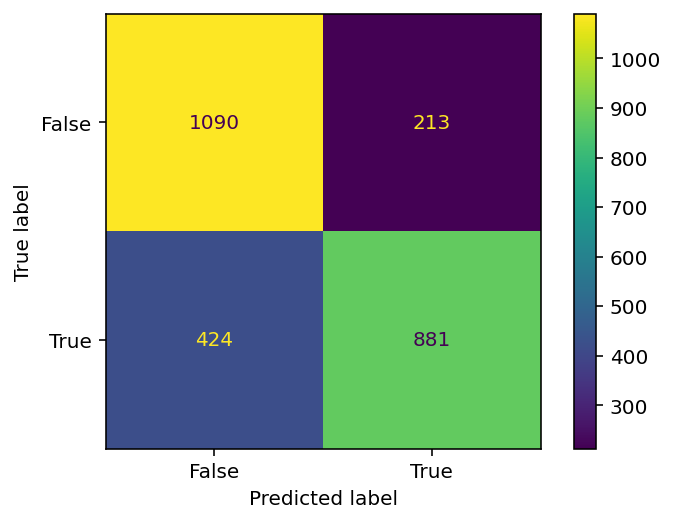

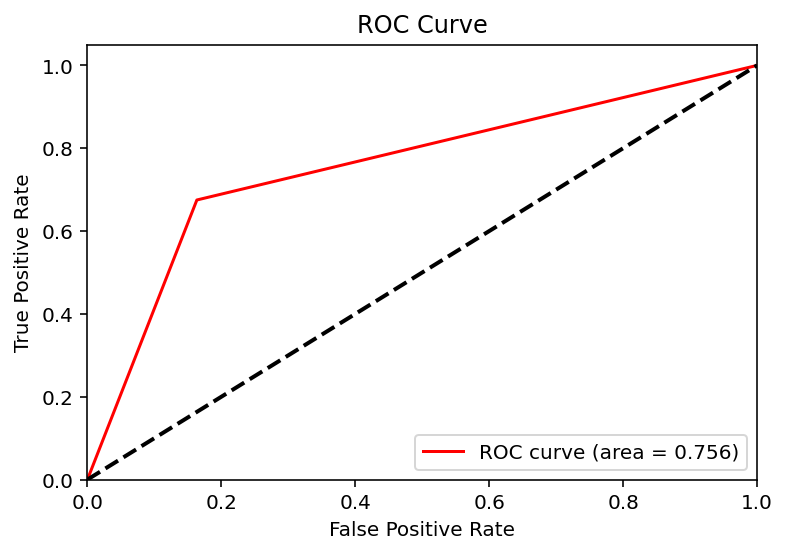

In [ ]:
#train.columns

#test.columns

pd.set_option('display.max_columns', 35)

train = train.astype('float64')
test = test.astype('float64')
target = target.astype('float64')

lst_for_scale = []
for col in train.columns:
    if len(train[col].value_counts()) != 2:
        lst_for_scale.append(col)

scaler = StandardScaler()

scaled_train = scaler.fit_transform(train[lst_for_scale])

scaled_test = scaler.transform(test[lst_for_scale])

scaled_train = pd.DataFrame(scaled_train)

for i in range(0,7):
    scaled_train = scaled_train.rename(columns={i:scaler.feature_names_in_[i]})

copy_train = train.drop(scaler.feature_names_in_,axis=1).copy()

train_final = pd.concat((scaled_train, copy_train), axis=1)

scaled_test = pd.DataFrame(scaled_test)

for i in range(0,7):
    scaled_test = scaled_test.rename(columns={i:scaler.feature_names_in_[i]})

copy_test = test.drop(scaler.feature_names_in_,axis=1).copy()

test_final = pd.concat((scaled_test, copy_test), axis=1)

# for col in train.columns:
#     sns.distplot(train[col])
#     plt.show()
#     sns.distplot(train_final[col])
#     plt.show()
#     print('===========================')
train_final.Age.describe()

#kfold= KFold(n_splits=5,random_state=42,shuffle=True) #kfold cross validation, 10-subsets
X_train, X_test, y_train, y_test = train_test_split(train_final, target, test_size=0.3,random_state=0)

X_train = torch.tensor(X_train.to_numpy()).float().cpu(); X_train.shape

y_train = torch.tensor(y_train.to_numpy()).view(-1,1).float().cpu(); y_train.shape

X_test = torch.tensor(X_test.to_numpy()).float().cpu(); X_test.shape

y_test = torch.tensor(y_test.to_numpy()).view(-1,1).float().cpu(); y_test.shape

model = nn.Sequential(nn.Linear(31,992),
                      nn.ReLU(),
                      nn.Linear(992,496),
                      nn.ReLU(),
                      nn.Linear(496,248),
                      nn.ReLU(),
                      nn.Linear(248,124),
                      nn.ReLU(),
                      nn.Linear(124,1),
                      nn.Sigmoid()).to('cpu')
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

accuracy_score(y_test.cpu(), (model(X_test).cpu().data.numpy() > 0.5))

accuracy_min = 0
epochs = 100
for e in range(epochs):    
    model.train()
    counter = 0
    for i in range(0,116):
        if counter != 7360:
            counter += 64
            X_batch = X_train[counter-64:counter]
            y_batch = y_train[counter-64:counter].view(-1,1)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        elif counter == 7360:
            counter += 29
            X_batch = X_train[counter-29:counter]
            y_batch = y_train[counter-29:counter].view(-1,1)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
    model.eval()
    loss = criterion(model(X_test), y_test)
    accuracy_ = accuracy_score(y_test.cpu(), (model(X_test).cpu().data.numpy() > 0.5))
    print(f"training loss of {e}th epoch number: {loss}, accuracy: {accuracy_}")
    if accuracy_ >= accuracy_min:
        print('Accuracy metrics increased ({:.6f} --> {:.6f}).  Saving model ...'.format(accuracy_min,accuracy_))
        accuracy_min = accuracy_
    print(f"best accuracy: {accuracy_min}")

# Confusion Matrix
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test,model(X_test).cpu().data.numpy() > 0.5)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, model(X_test).cpu().data.numpy() > 0.5)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()